Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

Soruce: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

In [42]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder

import os
import pickle
from datetime import datetime
from dateutil.parser import parse

%matplotlib inline


In [43]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

In [44]:
with open("all_converted_data.pkl", 'rb') as picklefile: 
    df_new = pickle.load(picklefile)
df_new.shape


(1370538, 13)

In [45]:
df_new.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,date,day,month,year
0,43580,14,1,8,439,2017-11-09 09:20:20,NaN,0,9,2017-11-09,9,11,2017
1,80000,12,1,17,212,2017-11-09 04:12:09,NaN,0,4,2017-11-09,9,11,2017
2,14792,14,1,19,489,2017-11-07 14:00:49,NaN,0,14,2017-11-07,7,11,2017
3,17030,9,1,25,334,2017-11-09 10:09:35,NaN,0,10,2017-11-09,9,11,2017
4,316658,9,1,41,232,2017-11-09 08:26:16,NaN,0,8,2017-11-09,9,11,2017


In [46]:
df_download = df_new[df_new.is_attributed == 1].sample(5000)
df_notDownload = df_new[df_new.is_attributed != 1].sample(5000*2)
df_all = df_notDownload.append(df_download, ignore_index=True)

In [47]:
df_all.shape

(15000, 13)

In [48]:
selectedFeatures=['ip', 'app', 'device', 'os', 'channel','hour']

In [49]:
df_all.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
hour                        int64
date                       object
day                         int64
month                       int64
year                        int64
dtype: object

In [50]:
X=df_all.loc[:, selectedFeatures]
y=df_all['is_attributed']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42, stratify=y)


In [52]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [53]:
def printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred):
    print("Test set Accuracy:     %.2f" % accuracy_score(y_train_p,y_train_pred))   
    print("------")
    print("Train set Accuracy:     %.2f" % accuracy_score(y_test_p,y_pred))
    print("F1:           %s" % f1_score(y_test_p, y_pred, average=None))
    print("F1(macro):    %.2f" % f1_score(y_test_p, y_pred, average='macro'))
    print("F1(weighted): %.2f" % f1_score(y_test_p, y_pred, average='weighted'))
    mat = confusion_matrix(y_test_p, y_pred)
    print(mat)
    
    # The random forest model by itself
    y_pred_rf = model.predict_proba(X_test_p)[:, 1]
    fpr_rf, tpr_rf, threshold = roc_curve(y_test_p, y_pred_rf)
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print("AUC: %.2f" %auc(fpr_rf, tpr_rf))
    precision, recall, thresholds = precision_recall_curve(y_test_p, y_pred_rf)
    
    print("precision %s" % precision)
    print("recall %s" % recall)
    
    from sklearn.metrics import recall_score, precision_score
    
    print("recall_score %s" % recall_score(y_test_p, y_pred, average=None))
    
    print("precision_score %s" % precision_score(y_test_p, y_pred, average=None) )
    
    
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    return fpr_rf, tpr_rf, threshold

In [54]:
def runSVC(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.svm import SVC
    model = SVC(probability=True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     1.00
------
Train set Accuracy:     0.67
F1:           [8.00064005e-01 7.99680128e-04]
F1(macro):    0.40
F1(weighted): 0.53
[[5000    0]
 [2499    1]]


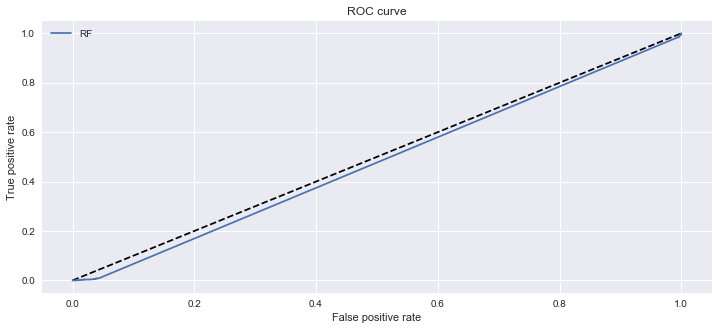

AUC: 0.48
precision [0.33333333 0.33324443 0.33315551 0.33319995 0.33311099 0.33302201
 0.33306645 0.3331109  0.33293285 0.3329773  0.33288824 0.33279915
 0.33271003 0.33262089 0.33244254 0.33235333 0.33239775 0.33230851
 0.33235294 0.33226367 0.33217438 0.33208506 0.33212948 0.33217391
 0.33208456 0.332129   0.33195021 0.33186078 0.33190521 0.33181575
 0.33172626 0.33177069 0.33181514 0.33185959 0.33181453 0.33176944
 0.33181392 0.33185841 0.33176881 0.33167918 0.33158954 0.33149987
 0.33154434 0.33145464 0.33136492 0.33127517 0.33118539 0.33122986
 0.33114006 0.33118453 0.33109469 0.33100484 0.09205021 0.09649123
 0.09049774 0.09090909 0.0913242  0.08715596 0.08796296 0.08372093
 0.08450704 0.08530806 0.08653846 0.08737864 0.07843137 0.07389163
 0.07425743 0.07537688 0.07070707 0.07106599 0.07142857 0.07179487
 0.06770833 0.06842105 0.06878307 0.06382979 0.06417112 0.06486486
 0.06521739 0.06557377 0.06593407 0.06629834 0.06666667 0.06703911
 0.06741573 0.06779661 0.06285714 0.063218

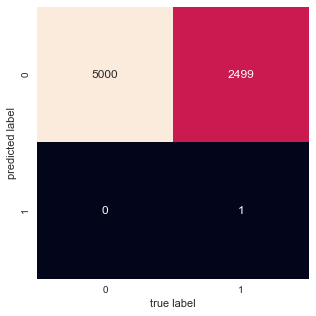

In [55]:
runSVC(X_train, y_train, X_test, y_test)

In [56]:
def runSVM(X_train_p, y_train_p, X_test_p, y_test_p):
    model = svm.SVC(probability = True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Attemp for other dataset from kaggle

Test set Accuracy:     1.00
------
Train set Accuracy:     0.67
F1:           [8.00064005e-01 7.99680128e-04]
F1(macro):    0.40
F1(weighted): 0.53
[[5000    0]
 [2499    1]]


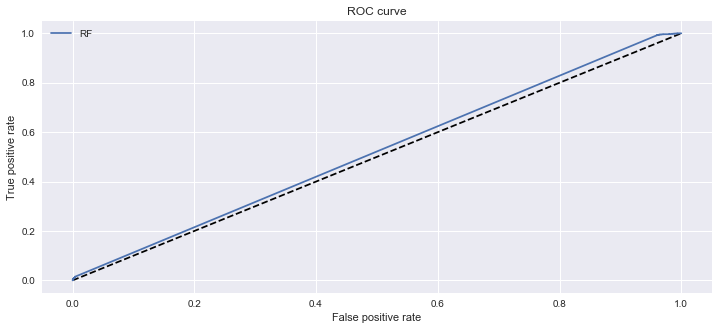

AUC: 0.52
precision [0.33458244 0.33449337 0.33453815 0.33458294 0.33462775 0.33467256
 0.33471739 0.33462827 0.3346731  0.33471794 0.3347628  0.33480767
 0.33485255 0.33489744 0.33494234 0.33498726 0.33503219 0.33507713
 0.33516705 0.33521202 0.33525701 0.33530201 0.33534703 0.33539205
 0.33543709 0.33539288 0.33543794 0.335483   0.33552808 0.33557318
 0.33561828 0.3356634  0.33570852 0.3356192  0.33566434 0.33570948
 0.33575464 0.33579981 0.33571044 0.33575562 0.33580081 0.33584601
 0.33589122 0.33593645 0.33598169 0.33602694 0.3360722  0.33611747
 0.33616276 0.33620806 0.33625337 0.33629869 0.33634403 0.33638938
 0.33629989 0.33630109 0.33634647 0.33643725 0.33648266 0.33652808
 0.33657351 0.33666442 0.33670989 0.33675537 0.33684637 0.33689189
 0.33693742 0.33698297 0.33702853 0.33693889 0.33698445 0.33689478
 0.33694035 0.33698593 0.33703152 0.33707713 0.33712275 0.33721402
 0.33725968 0.33730535 0.33735103 0.33739672 0.33744243 0.33748815
 0.33753388 0.33757962 0.33762537 0.337671

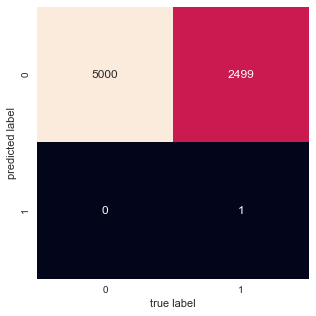

In [57]:
runSVM(X_train, y_train, X_test, y_test)

In [58]:
def runGaussianNB(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.naive_bayes import GaussianNB

    # Initialize our classifier
    model = GaussianNB()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.77
------
Train set Accuracy:     0.77
F1:           [0.84531038 0.56948298]
F1(macro):    0.71
F1(weighted): 0.75
[[4664  336]
 [1371 1129]]


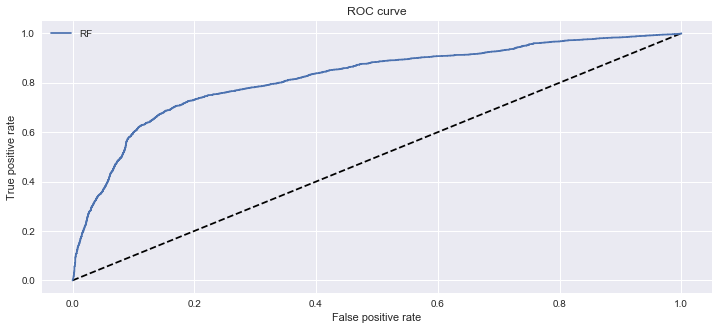

AUC: 0.82
precision [0.33333333 0.33324443 0.33315551 ... 0.81818182 0.8125     1.        ]
recall [1.     0.9996 0.9992 ... 0.0108 0.0104 0.    ]
recall_score [0.9328 0.4516]
precision_score [0.77282519 0.77064846]


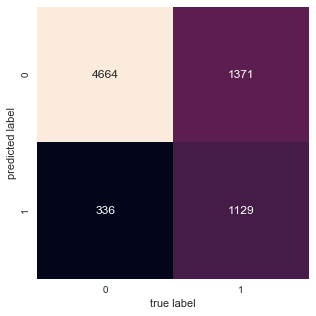

In [59]:
runGaussianNB(X_train, y_train, X_test, y_test)

In [60]:
def runLog(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.linear_model import LogisticRegression
    # Initialize our classifier
    model = LogisticRegression()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.77
------
Train set Accuracy:     0.78
F1:           [0.84349672 0.65012942]
F1(macro):    0.75
F1(weighted): 0.78
[[4371  629]
 [ 993 1507]]


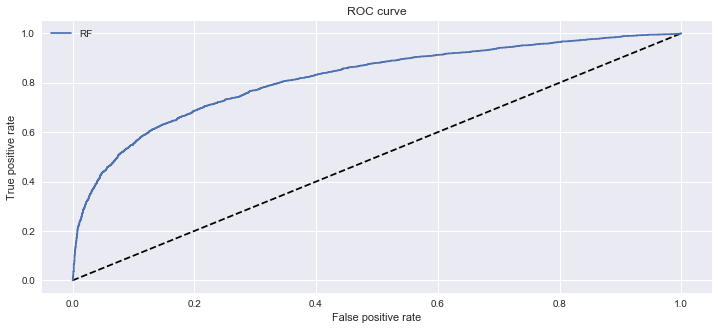

AUC: 0.82
precision [0.33333333 0.33324443 0.33315551 ... 1.         1.         1.        ]
recall [1.000e+00 9.996e-01 9.992e-01 ... 8.000e-04 4.000e-04 0.000e+00]
recall_score [0.8742 0.6028]
precision_score [0.81487696 0.70552434]


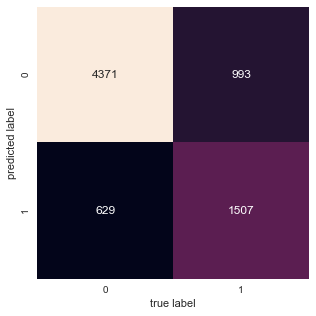

In [61]:
runLog(X_train, y_train, X_test, y_test)

In [62]:
def runRandom(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy

Test set Accuracy:     0.99
------
Train set Accuracy:     0.92
F1:           [0.9436196  0.87625133]
F1(macro):    0.91
F1(weighted): 0.92
[[4862  138]
 [ 443 2057]]


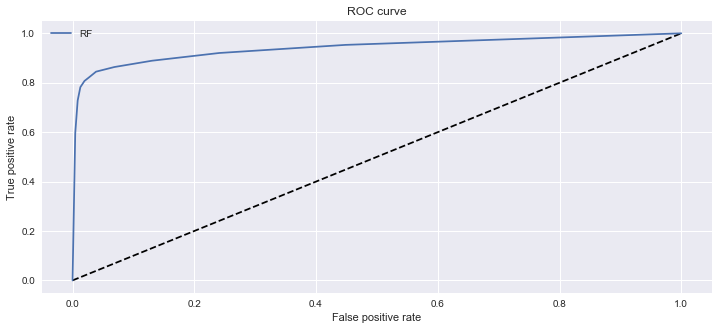

AUC: 0.94
precision [0.33333333 0.51490925 0.51502053 0.6559293  0.65611634 0.7724114
 0.77267987 0.86256492 0.91626898 0.93712984 0.9536862  0.96830114
 0.97744361 0.98544011 1.        ]
recall [1.     0.9532 0.9532 0.9204 0.9204 0.8892 0.8892 0.8636 0.8448 0.8228
 0.8072 0.782  0.728  0.5956 0.    ]
recall_score [0.9724 0.8228]
precision_score [0.91649387 0.93712984]
Model Performance
Average Error: 0.0775 degrees.
Accuracy = -inf%.
-inf


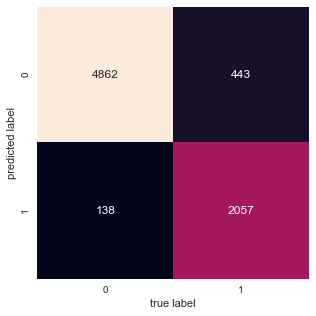

In [63]:
randForest_model,base_accuracy = runRandom(X_train, y_train, X_test, y_test)

In [64]:
#code source: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

In [65]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [66]:
def runRandomGrid(X_train_p, y_train_p, X_test_p, y_test_p, base_accuracy):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }
    model = RandomForestRegressor(random_state = 42)
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(X_train_p, y_train_p)
    print(grid_search.best_params_)

    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, X_test_p, y_test_p)

    print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


    
    #printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    
   
    return model, grid_search.best_params_

In [67]:
randForest_model, best_fit_rf = runRandomGrid(X_train, y_train, X_test, y_test, base_accuracy)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_le

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   8.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   7.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_s

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   6.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sa

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_f

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.9min


[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   9.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.7s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.4s
[CV] bootstrap=True, max_depth=110, max_f

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.7min finished


{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 1000}
Model Performance
Average Error: 0.1219 degrees.
Accuracy = -inf%.
Improvement of nan%.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [68]:
# best_fit_rf={'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}

In [69]:
def runRandom_best(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42,**best_fit_rf)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    fpr_rf, tpr_rf, threshold = printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy, fpr_rf, tpr_rf, threshold

Test set Accuracy:     0.94
------
Train set Accuracy:     0.93
F1:           [0.94899835 0.88707949]
F1(macro):    0.92
F1(weighted): 0.93
[[4903   97]
 [ 430 2070]]


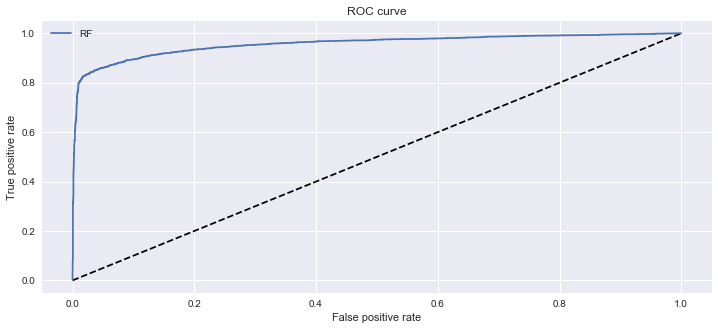

AUC: 0.96
precision [0.33534541 0.33525624 0.33530122 ... 1.         1.         1.        ]
recall [1.     0.9996 0.9996 ... 0.0056 0.0052 0.    ]
recall_score [0.9806 0.828 ]
precision_score [0.91936996 0.95523766]
Model Performance
Average Error: 0.0703 degrees.
Accuracy = -inf%.
-inf


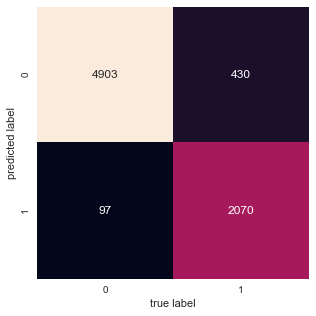

In [70]:
randForest_best_model,best_grid_accuracy, fpr, tpr, thr = runRandom_best(X_train, y_train, X_test, y_test)

In [71]:
fpr, tpr, thr

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04,
        2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04,
        2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 4.000e-04,
        4.000e-04, 4.000e-04, 4.000e-04, 4.000e-04, 4.000e-04, 6.000e-04,
        6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04,
        6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04, 6.000e-04,
        6.000e-04, 8.000e-04, 8.000e-04, 1.000e-03, 1.000e-03, 1.200e-03,
        1.200e-03, 1.200e-03, 1.200e-03, 1.200e-03, 1.400e-03, 1.400e-03,
        1.400e-03, 1.400e-03, 1.400e-03, 1.400e-03, 1.600e-03, 1.600e-03,
        1.600e-03, 1.600e-03, 1.800e-0

In [80]:
def RunThreadhold(t):
    change_t_y_predict = (randForest_best_model.predict_proba(X_test)[:,1] > t)
    change_t_y_predict
    mit_tr = confusion_matrix(y_test, change_t_y_predict)
    sns.heatmap(mit_tr.T, square=True, annot=True, fmt='d', cbar=False)
    from sklearn.metrics import recall_score, precision_score
    re_score = recall_score(y_test, change_t_y_predict, average=None)
    #print("recall_score %s" % re_score)
    pr_score = precision_score(y_test, change_t_y_predict, average=None)

    #print("precision_score %s" % pr_score)
    result =  {"recall": re_score,"precision": pr_score, "threshold": t}
    print(result)
    return result;



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'recall': array([1., 0.]), 'precision': array([0.66666667, 0.        ]), 'threshold': 1.0}
{'recall': array([1.    , 0.0056]), 'precision': array([0.66791344, 1.        ]), 'threshold': 0.9999444444444444}
{'recall': array([1.   , 0.006]), 'precision': array([0.66800267, 1.        ]), 'threshold': 0.9999375}
{'recall': array([1.   , 0.008]), 'precision': array([0.6684492, 1.       ]), 'threshold': 0.9999333333333333}
{'recall': array([1.    , 0.0084]), 'precision': array([0.66853857, 1.        ]), 'threshold': 0.9999321923177423}
{'recall': array([1.    , 0.0096]), 'precision': array([0.66880685, 1.        ]), 'threshold': 0.9999124607520994}
{'recall': array([1.    , 0.0112]), 'precision': array([0.66916488, 1.        ]), 'threshold': 0.999910922290561}
{'recall': array([1.    , 0.0124]), 'precision': array([0.66943366, 1.        ]), 'threshold': 0.9999045454545455}
{'recall': array([1.    , 0.0128]), 'precision': array([0.6695233, 1.       ]), 'threshold': 0.9998888888888889}
{'reca

{'recall': array([0.9986, 0.3436]), 'precision': array([0.75263793, 0.99191686]), 'threshold': 0.9895335258051786}
{'recall': array([0.9986, 0.4036]), 'precision': array([0.77004935, 0.99311024]), 'threshold': 0.9852879857280248}
{'recall': array([0.9986, 0.404 ]), 'precision': array([0.77016813, 0.99311701]), 'threshold': 0.9852299689431067}
{'recall': array([0.9986, 0.4296]), 'precision': array([0.77784702, 0.99352451]), 'threshold': 0.982864497887428}
{'recall': array([0.9986, 0.43  ]), 'precision': array([0.77796821, 0.9935305 ]), 'threshold': 0.9827990632949936}
{'recall': array([0.9984, 0.436 ]), 'precision': array([0.77975633, 0.99271403]), 'threshold': 0.9824115248656842}
{'recall': array([0.9984, 0.4364]), 'precision': array([0.77987814, 0.99272066]), 'threshold': 0.9823593342559906}
{'recall': array([0.9984, 0.4448]), 'precision': array([0.78244514, 0.99285714]), 'threshold': 0.981608026888832}
{'recall': array([0.9984, 0.4452]), 'precision': array([0.7825678 , 0.99286351]), 

{'recall': array([0.9918, 0.7588]), 'precision': array([0.89158576, 0.97884417]), 'threshold': 0.8666110972786389}
{'recall': array([0.9916, 0.762 ]), 'precision': array([0.89285071, 0.97842835]), 'threshold': 0.860961170495298}
{'recall': array([0.9916, 0.7624]), 'precision': array([0.89301153, 0.97843943]), 'threshold': 0.8606366650383093}
{'recall': array([0.9914, 0.7652]), 'precision': array([0.89411977, 0.97801636]), 'threshold': 0.8553172043134698}
{'recall': array([0.9914, 0.7656]), 'precision': array([0.89428108, 0.97802759]), 'threshold': 0.8548453474586986}
{'recall': array([0.9912, 0.7672]), 'precision': array([0.89490791, 0.9775739 ]), 'threshold': 0.8511822954508934}
{'recall': array([0.9912, 0.7676]), 'precision': array([0.89506953, 0.97758533]), 'threshold': 0.8498272605149791}
{'recall': array([0.991 , 0.7684]), 'precision': array([0.89537405, 0.97711089]), 'threshold': 0.849429930441852}
{'recall': array([0.991 , 0.7688]), 'precision': array([0.89553588, 0.97712252]), 

{'recall': array([0.9828, 0.8244]), 'precision': array([0.91798991, 0.95994411]), 'threshold': 0.531426722064333}
{'recall': array([0.9826, 0.8256]), 'precision': array([0.91848944, 0.9595537 ]), 'threshold': 0.5263711705566354}
{'recall': array([0.9822, 0.826 ]), 'precision': array([0.91863075, 0.95868152]), 'threshold': 0.5237959113558821}
{'recall': array([0.982 , 0.8268]), 'precision': array([0.91895939, 0.95827538]), 'threshold': 0.5184611025726268}
{'recall': array([0.982 , 0.8272]), 'precision': array([0.91913141, 0.95829472]), 'threshold': 0.5159231581181121}
{'recall': array([0.9818, 0.8272]), 'precision': array([0.91911627, 0.95785086]), 'threshold': 0.5135521523600239}
{'recall': array([0.9818, 0.8276]), 'precision': array([0.91928839, 0.95787037]), 'threshold': 0.5135172323098376}
{'recall': array([0.9816, 0.8276]), 'precision': array([0.91927327, 0.95742712]), 'threshold': 0.5134551543665993}
{'recall': array([0.9808, 0.828 ]), 'precision': array([0.91938508, 0.95567867]),

{'recall': array([0.9648, 0.8472]), 'precision': array([0.92662313, 0.92327812]), 'threshold': 0.39445849888912216}
{'recall': array([0.9646, 0.8488]), 'precision': array([0.92732167, 0.92301   ]), 'threshold': 0.3935870843593442}
{'recall': array([0.9636, 0.8492]), 'precision': array([0.92743022, 0.92104121]), 'threshold': 0.38643445690626005}
{'recall': array([0.9634, 0.8492]), 'precision': array([0.92741625, 0.9206418 ]), 'threshold': 0.38580355701801855}
{'recall': array([0.963 , 0.8496]), 'precision': array([0.92756694, 0.91987874]), 'threshold': 0.38526246643251477}
{'recall': array([0.9628, 0.85  ]), 'precision': array([0.92773174, 0.91951536]), 'threshold': 0.38447288591447654}
{'recall': array([0.9628, 0.8504]), 'precision': array([0.92791056, 0.91955017]), 'threshold': 0.3839246842353267}
{'recall': array([0.9626, 0.8504]), 'precision': array([0.92789666, 0.91915262]), 'threshold': 0.38339998741298204}
{'recall': array([0.9626, 0.8508]), 'precision': array([0.92807559, 0.9191

{'recall': array([0.9374, 0.8712]), 'precision': array([0.93571571, 0.87434765]), 'threshold': 0.29620354787111736}
{'recall': array([0.9372, 0.8712]), 'precision': array([0.93570288, 0.87399679]), 'threshold': 0.2959842018946091}
{'recall': array([0.9372, 0.8716]), 'precision': array([0.93588975, 0.87404733]), 'threshold': 0.295644171621128}
{'recall': array([0.937, 0.872]), 'precision': array([0.93606394, 0.87374749]), 'threshold': 0.29494276508665046}
{'recall': array([0.9356, 0.8724]), 'precision': array([0.9361617 , 0.87135437]), 'threshold': 0.292093954895294}
{'recall': array([0.9354, 0.8724]), 'precision': array([0.93614892, 0.87100639]), 'threshold': 0.29203725687216575}
{'recall': array([0.9332, 0.8728]), 'precision': array([0.93619583, 0.8672496 ]), 'threshold': 0.2897948181263402}
{'recall': array([0.933 , 0.8728]), 'precision': array([0.93618302, 0.86690505]), 'threshold': 0.28971755602008514}
{'recall': array([0.933 , 0.8732]), 'precision': array([0.93637094, 0.8669579 ])

{'recall': array([0.9044, 0.8924]), 'precision': array([0.94385306, 0.82355113]), 'threshold': 0.22891317021509153}
{'recall': array([0.9042, 0.8928]), 'precision': array([0.94403842, 0.82331243]), 'threshold': 0.22821234065862364}
{'recall': array([0.9036, 0.8932]), 'precision': array([0.94420063, 0.82246777]), 'threshold': 0.22685264848259531}
{'recall': array([0.9034, 0.8932]), 'precision': array([0.94418896, 0.82216495]), 'threshold': 0.22671881925424933}
{'recall': array([0.9024, 0.8936]), 'precision': array([0.94432817, 0.82072006]), 'threshold': 0.2250962373162503}
{'recall': array([0.9022, 0.8936]), 'precision': array([0.94431652, 0.82041866]), 'threshold': 0.2247692603190822}
{'recall': array([0.9006, 0.894 ]), 'precision': array([0.94442114, 0.81808199]), 'threshold': 0.22326375962788506}
{'recall': array([0.9004, 0.894 ]), 'precision': array([0.94440948, 0.81778266]), 'threshold': 0.22315665484602878}
{'recall': array([0.8998, 0.8944]), 'precision': array([0.94457275, 0.8169

{'recall': array([0.8736, 0.9096]), 'precision': array([0.9508054 , 0.78251893]), 'threshold': 0.18950102962893897}
{'recall': array([0.8734, 0.91  ]), 'precision': array([0.95100174, 0.78232462]), 'threshold': 0.1890923839146751}
{'recall': array([0.8732, 0.91  ]), 'precision': array([0.95099107, 0.78205569]), 'threshold': 0.18899261218470775}
{'recall': array([0.8726, 0.9104]), 'precision': array([0.95116634, 0.78132509]), 'threshold': 0.1885796077073943}
{'recall': array([0.8724, 0.9104]), 'precision': array([0.95115569, 0.78105697]), 'threshold': 0.1885787217856104}
{'recall': array([0.8712, 0.9108]), 'precision': array([0.95129941, 0.77952756]), 'threshold': 0.18826112040433238}
{'recall': array([0.871 , 0.9108]), 'precision': array([0.95128877, 0.77926078]), 'threshold': 0.18813086679402483}
{'recall': array([0.8696, 0.9112]), 'precision': array([0.95142232, 0.7774744 ]), 'threshold': 0.18684628659641953}
{'recall': array([0.8694, 0.9116]), 'precision': array([0.95161996, 0.77728

{'recall': array([0.8164, 0.9292]), 'precision': array([0.95844095, 0.71675409]), 'threshold': 0.1471406907027106}
{'recall': array([0.8162, 0.9292]), 'precision': array([0.95843119, 0.716533  ]), 'threshold': 0.14698827277899282}
{'recall': array([0.8154, 0.9296]), 'precision': array([0.95861745, 0.7157376 ]), 'threshold': 0.14596269048289182}
{'recall': array([0.8152, 0.9296]), 'precision': array([0.95860771, 0.71551724]), 'threshold': 0.14594589352769693}
{'recall': array([0.8096, 0.93  ]), 'precision': array([0.95856027, 0.70949039]), 'threshold': 0.14262766481647562}
{'recall': array([0.8094, 0.93  ]), 'precision': array([0.95855045, 0.70927395]), 'threshold': 0.14250063904884858}
{'recall': array([0.8082, 0.9304]), 'precision': array([0.95871886, 0.70806697]), 'threshold': 0.14200050363524988}
{'recall': array([0.808 , 0.9304]), 'precision': array([0.95870907, 0.70785149]), 'threshold': 0.14189918125172762}
{'recall': array([0.8074, 0.9308]), 'precision': array([0.95890736, 0.707

{'recall': array([0.754, 0.944]), 'precision': array([0.96419437, 0.65738162]), 'threshold': 0.11581346491878042}
{'recall': array([0.7496, 0.9444]), 'precision': array([0.96423977, 0.65347357]), 'threshold': 0.11362878563065841}
{'recall': array([0.7494, 0.9444]), 'precision': array([0.96423057, 0.65329275]), 'threshold': 0.11361358086320747}
{'recall': array([0.748 , 0.9448]), 'precision': array([0.96441465, 0.6521259 ]), 'threshold': 0.1131541450703543}
{'recall': array([0.7478, 0.9448]), 'precision': array([0.96440547, 0.6519459 ]), 'threshold': 0.11314251693495041}
{'recall': array([0.744 , 0.9452]), 'precision': array([0.96448017, 0.64864123]), 'threshold': 0.11129980853620151}
{'recall': array([0.7438, 0.9452]), 'precision': array([0.96447095, 0.64846323]), 'threshold': 0.11129524411993393}
{'recall': array([0.7422, 0.9456]), 'precision': array([0.96464778, 0.64713934]), 'threshold': 0.1110241572978107}
{'recall': array([0.742 , 0.9456]), 'precision': array([0.96463859, 0.646962

{'recall': array([0.6634, 0.9588]), 'precision': array([0.96988304, 0.5875    ]), 'threshold': 0.08447447199343493}
{'recall': array([0.6632, 0.9588]), 'precision': array([0.96987423, 0.58735604]), 'threshold': 0.0844583757013392}
{'recall': array([0.6626, 0.9592]), 'precision': array([0.97013177, 0.5870257 ]), 'threshold': 0.08435722454532063}
{'recall': array([0.6624, 0.9592]), 'precision': array([0.97012302, 0.58688204]), 'threshold': 0.0843221865380175}
{'recall': array([0.658 , 0.9596]), 'precision': array([0.97021528, 0.58384035]), 'threshold': 0.0830773194145021}
{'recall': array([0.6578, 0.9596]), 'precision': array([0.97020649, 0.5836983 ]), 'threshold': 0.08297898559600354}
{'recall': array([0.6532, 0.96  ]), 'precision': array([0.97029115, 0.58055152]), 'threshold': 0.08169546849243094}
{'recall': array([0.653, 0.96 ]), 'precision': array([0.97028232, 0.58041112]), 'threshold': 0.08168293155006373}
{'recall': array([0.652 , 0.9604]), 'precision': array([0.97052694, 0.5798116

{'recall': array([0.5072, 0.9724]), 'precision': array([0.97351248, 0.49662921]), 'threshold': 0.05247352159800386}
{'recall': array([0.5062, 0.9728]), 'precision': array([0.97383609, 0.49622526]), 'threshold': 0.05240128531169553}
{'recall': array([0.506 , 0.9728]), 'precision': array([0.97382602, 0.49612403]), 'threshold': 0.05238995205001403}
{'recall': array([0.5048, 0.9732]), 'precision': array([0.97414126, 0.49562029]), 'threshold': 0.052029276606606376}
{'recall': array([0.5046, 0.9732]), 'precision': array([0.97413127, 0.49551935]), 'threshold': 0.05202110386603426}
{'recall': array([0.4986, 0.9736]), 'precision': array([0.97420868, 0.49261283]), 'threshold': 0.051165768661163416}
{'recall': array([0.4984, 0.9736]), 'precision': array([0.97419859, 0.49251315]), 'threshold': 0.05114950187841066}
{'recall': array([0.4942, 0.974 ]), 'precision': array([0.97436909, 0.49053183]), 'threshold': 0.0504519706312027}
{'recall': array([0.494, 0.974]), 'precision': array([0.97435897, 0.490

{'recall': array([0.2898, 0.9872]), 'precision': array([0.97839298, 0.41003489]), 'threshold': 0.023581593398002053}
{'recall': array([0.2896, 0.9872]), 'precision': array([0.97837838, 0.40996678]), 'threshold': 0.023564795153484155}
{'recall': array([0.2836, 0.9876]), 'precision': array([0.97860594, 0.40803173]), 'threshold': 0.023009291732041987}
{'recall': array([0.2834, 0.9876]), 'precision': array([0.97859116, 0.40796431]), 'threshold': 0.023005519609853507}
{'recall': array([0.2804, 0.988 ]), 'precision': array([0.97905028, 0.40705339]), 'threshold': 0.022714062435064707}
{'recall': array([0.2802, 0.988 ]), 'precision': array([0.97903564, 0.40698632]), 'threshold': 0.022691549250194423}
{'recall': array([0.2696, 0.9884]), 'precision': array([0.97893972, 0.40356035]), 'threshold': 0.021737734483438808}
{'recall': array([0.2694, 0.9884]), 'precision': array([0.97892442, 0.40349445]), 'threshold': 0.021728201498672082}
{'recall': array([0.2682, 0.9888]), 'precision': array([0.979547

[{'recall': array([1., 0.]),
  'precision': array([0.66666667, 0.        ]),
  'threshold': 1.0},
 {'recall': array([1.    , 0.0056]),
  'precision': array([0.66791344, 1.        ]),
  'threshold': 0.9999444444444444},
 {'recall': array([1.   , 0.006]),
  'precision': array([0.66800267, 1.        ]),
  'threshold': 0.9999375},
 {'recall': array([1.   , 0.008]),
  'precision': array([0.6684492, 1.       ]),
  'threshold': 0.9999333333333333},
 {'recall': array([1.    , 0.0084]),
  'precision': array([0.66853857, 1.        ]),
  'threshold': 0.9999321923177423},
 {'recall': array([1.    , 0.0096]),
  'precision': array([0.66880685, 1.        ]),
  'threshold': 0.9999124607520994},
 {'recall': array([1.    , 0.0112]),
  'precision': array([0.66916488, 1.        ]),
  'threshold': 0.999910922290561},
 {'recall': array([1.    , 0.0124]),
  'precision': array([0.66943366, 1.        ]),
  'threshold': 0.9999045454545455},
 {'recall': array([1.    , 0.0128]),
  'precision': array([0.6695233, 1

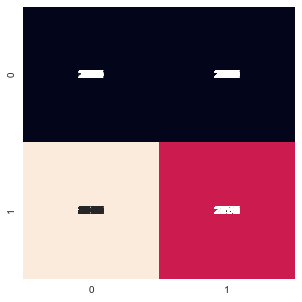

In [84]:
[RunThreadhold(i) for i in thr]

In [82]:
with open('randForest_best_model.pkl', 'wb') as picklefile:
    pickle.dump(randForest_best_model, picklefile)

In [75]:
X_train.columns[0]

'ip'

Feature ranking:
1. app (0.521302)
2. channel (0.193349)
3. ip (0.135282)
4. device (0.082823)
5. os (0.038297)
6. hour (0.028946)


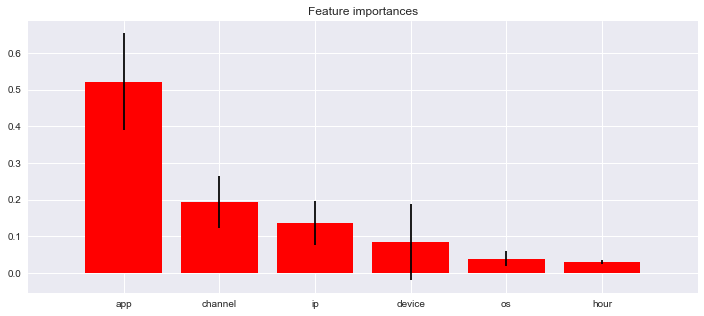

In [76]:
importances = randForest_best_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in randForest_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
cols = [X_train.columns[indices[f]] for f in range(X.shape[1])]
for f in range(X.shape[1]):
    #print(X_train.columns[indices[f]])
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), cols)
plt.xlim([-1, X.shape[1]])
plt.show()

In [77]:
indices

array([1, 4, 0, 2, 3, 5])

In [83]:

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
train_pool = Pool(X_train,y_train)
cat_model = CatBoostClassifier(iterations=25, learning_rate=0.1)
cat_model.fit(train_pool, eval_set=(X_test, y_test),plot=True)


0:	learn: 0.6072991	test: 0.6058422	best: 0.6058422 (0)	total: 39.7ms	remaining: 953ms
1:	learn: 0.5382542	test: 0.5363498	best: 0.5363498 (1)	total: 64.7ms	remaining: 744ms
2:	learn: 0.4873369	test: 0.4853419	best: 0.4853419 (2)	total: 99.3ms	remaining: 728ms
3:	learn: 0.4375377	test: 0.4350722	best: 0.4350722 (3)	total: 133ms	remaining: 698ms
4:	learn: 0.4055832	test: 0.4023829	best: 0.4023829 (4)	total: 161ms	remaining: 645ms
5:	learn: 0.3785565	test: 0.3749778	best: 0.3749778 (5)	total: 190ms	remaining: 601ms
6:	learn: 0.3593290	test: 0.3553561	best: 0.3553561 (6)	total: 215ms	remaining: 552ms
7:	learn: 0.3391763	test: 0.3354885	best: 0.3354885 (7)	total: 242ms	remaining: 514ms
8:	learn: 0.3248595	test: 0.3214308	best: 0.3214308 (8)	total: 274ms	remaining: 488ms
9:	learn: 0.3098815	test: 0.3064237	best: 0.3064237 (9)	total: 305ms	remaining: 458ms
10:	learn: 0.2979653	test: 0.2936789	best: 0.2936789 (10)	total: 338ms	remaining: 431ms
11:	learn: 0.2908167	test: 0.2869146	best: 0.2869

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [79]:
df_ad = pd.read_csv('data/test.csv')
df_ad

FileNotFoundError: File b'data/test.csv' does not exist

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [ ]:
def convertDF(df_old):
    df_old['click_time'] = pd.to_datetime(df_old['click_time'], format='%Y/%m/%d %H:%M:%S')
    df_old['hour']=df_old['click_time'].dt.hour
    df_old['date']=df_old['click_time'].dt.date
    df_old['day']=df_old['click_time'].dt.day
    df_old['month']=df_old['click_time'].dt.month
    df_old['year']=df_old['click_time'].dt.year
    return df_old

In [ ]:
df_new = convertDF(df_ad)
df_new.head()

In [ ]:
x = df_new.loc[:, ['ip', 'app', 'device', 'os', 'channel', 'hour']]

In [ ]:
sub_cat_2 = cat_model.predict(x)
sub_cat_2

In [ ]:
df_new_sub = df_new

In [ ]:
# len(df_new_sub['is_attributed']==1)

In [ ]:
df_new_sub['is_attributed'] = sub_cat_2


In [ ]:
df_new_sub = df_new_sub.drop(['ip', 'app', 'device', 'os', 'channel', 'click_time',
       'hour', 'date', 'day', 'month', 'year'], axis=1)

In [ ]:
df_new_sub.to_csv('submission_second.csv', index=False)